In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [86]:
data = pd.read_csv('AMZN.csv')

In [87]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [88]:
data = data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

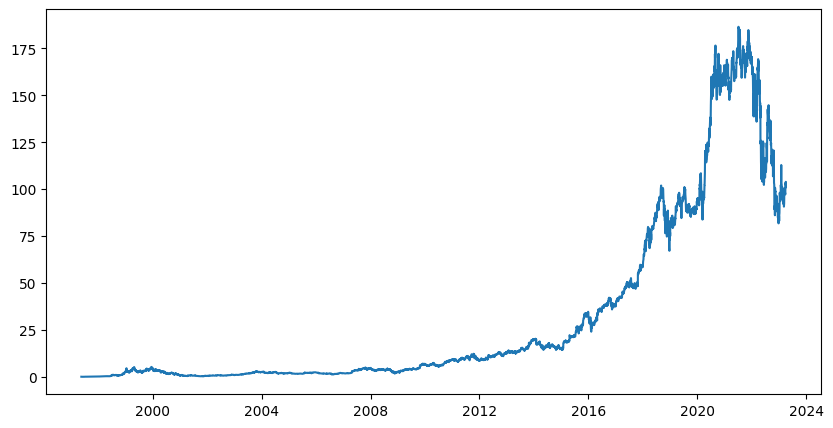

In [90]:
data['Date'] = pd.to_datetime(data['Date'])
data
plt.figure(figsize=(10,5))
plt.plot(data['Date'],data['Close'])
plt.show()

In [91]:
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df,n_steps):
  df = dc(df)
  df.set_index('Date',inplace=True)

  for i in range(1,n_steps+1):
    df[f'Close-{i}'] = df['Close'].shift(i)
  df.dropna(inplace=True)
  return df

look_back = 7
shifted_data = prepare_dataframe_for_lstm(data,look_back)
shifted_data

,Close,Close-1,Close-2,Close-3,Close-4,Close-5,Close-6,Close-7
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [92]:
shifted_df_as_np = shifted_data.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [94]:
X = shifted_df_as_np[:,1:]
Y = shifted_df_as_np[:,0]
X.shape,Y.shape

((6509, 7), (6509,))

In [95]:
X = dc(np.flip(X,axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [96]:
split_index = int(len(X)*0.95)
split_index

6183

In [97]:
X_trai = X[:split_index]
X_tes = X[split_index:]
Y_trai = Y[:split_index]
Y_tes = Y[split_index:]
X_trai.shape,X_tes.shape,Y_trai.shape,Y_tes.shape

((6183, 7), (326, 7), (6183,), (326,))

In [98]:
X_trai = X_trai.reshape(-1,look_back,1)
X_tes = X_tes.reshape(-1,look_back,1)
Y_trai = Y_trai.reshape(-1,1)
Y_tes = Y_tes.reshape(-1,1)
X_trai.shape,X_tes.shape,Y_trai.shape,Y_tes.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [99]:
X_trai = torch.from_numpy(X_trai).float()
X_tes = torch.from_numpy(X_tes).float()
Y_trai = torch.from_numpy(Y_trai).float()
Y_tes = torch.from_numpy(Y_tes).float()
X_trai.shape,X_tes.shape,Y_trai.shape,Y_tes.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [100]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset): # Change the argument name from Dataset to something else, like BaseDataset
  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

train_dataset = TimeSeriesDataset(X_trai,Y_trai)
test_dataset = TimeSeriesDataset(X_tes,Y_tes)

In [101]:
from torch.utils.data import DataLoader

batch_size = 16
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=True)

In [102]:
for _,batch in enumerate(train_dataloader):
  x_batch,y_batch = batch[0].to(device),batch[1].to(device)
  print(x_batch.shape,y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [103]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out,_ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1,4,1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [104]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch+1}')
  running_loss = 0.00
  for batch_idx,(x_batch,y_batch) in enumerate(train_dataloader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 99:
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_idx+1,avg_loss_across_batches))
      running_loss = 0.0
print()

In [105]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_dataloader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [106]:
learning_rate = 0.001
num_epoch = 10
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epoch):
  train_one_epoch()
  validate_one_epoch()



Epoch: 1
Batch 100, Loss: 0.364
Batch 200, Loss: 0.137
Batch 300, Loss: 0.057
Val Loss: 0.046
***************************************************

Epoch: 2
Batch 100, Loss: 0.018
Batch 200, Loss: 0.013
Batch 300, Loss: 0.010
Val Loss: 0.017
***************************************************

Epoch: 3
Batch 100, Loss: 0.006
Batch 200, Loss: 0.004
Batch 300, Loss: 0.003
Val Loss: 0.006
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Val Loss: 0.004
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Val Loss: 0.004
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Val Loss: 0.005
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Val Loss: 0.005
************************

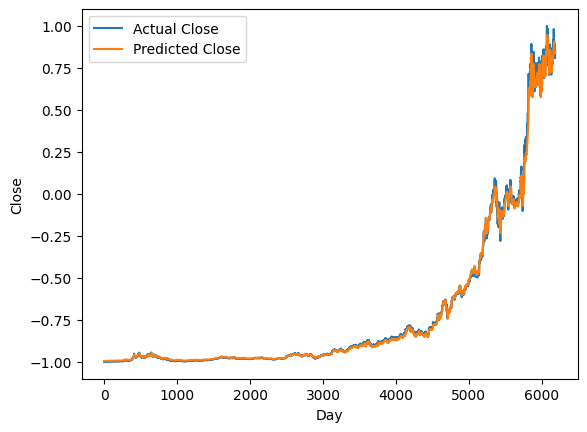

In [107]:
with torch.no_grad():
    predicted = model(X_trai.to(device)).to('cpu').numpy()

plt.plot(Y_trai, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [108]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_trai.shape[0], look_back+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.57252031,   0.573543  ,   0.57365416, ..., 171.55191385,
       171.30832355, 171.64167754])

In [109]:
dummies = np.zeros((X_trai.shape[0], look_back+1))
dummies[:, 0] = Y_trai.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

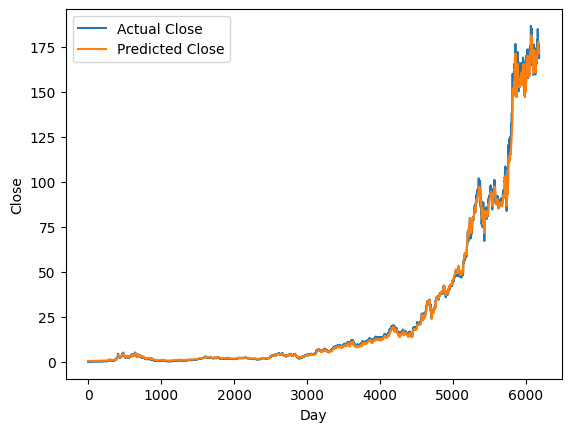

In [110]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [111]:
test_predictions = model(X_tes.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_tes.shape[0], look_back+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([170.57242805, 169.83366457, 168.75845677, 168.64528227,
       168.89652055, 169.18844429, 168.72249572, 168.987696  ,
       168.8203298 , 168.91848625, 168.26903069, 168.31760868,
       167.74951292, 166.80505997, 165.60497783, 164.5055922 ,
       163.32233449, 163.26327388, 162.65736065, 161.61278923,
       161.27226526, 160.36297856, 159.07742915, 156.96719879,
       152.35103306, 148.71026235, 144.65374403, 140.74218157,
       137.90075788, 136.81530647, 137.6238911 , 139.4809962 ,
       140.77619728, 139.51310547, 143.34801309, 146.42234991,
       149.62412895, 151.75772566, 153.02203191, 152.99080638,
       154.98681731, 154.75801161, 154.86727875, 153.71184501,
       152.24278306, 150.60314786, 148.51217084, 148.08341723,
       147.98012507, 147.62966318, 147.13397865, 147.16623243,
       146.44879546, 145.96195946, 142.68480116, 139.24418958,
       137.12202871, 137.37348654, 137.04354246, 136.28022318,
       137.22027688, 140.09609422, 143.75309465, 147.61

In [112]:
dummies = np.zeros((X_tes.shape[0], look_back+1))
dummies[:, 0] = Y_tes.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

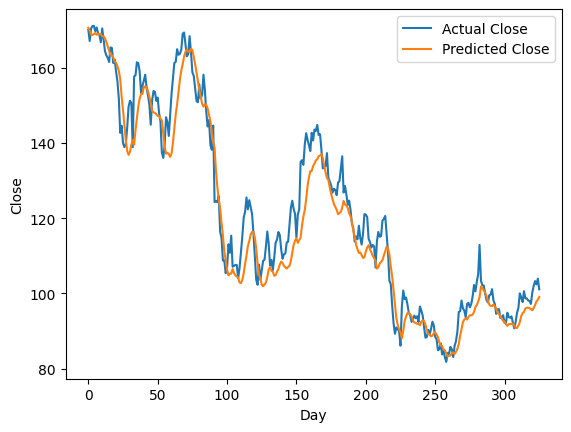

In [113]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
